In [53]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
from keras.layers import Dense, LSTM, TimeDistributed
py.init_notebook_mode(connected=True)
%matplotlib inline

In [99]:
data = pd.read_csv(filepath_or_buffer="./Data/growth_rate.csv", index_col="date")

In [100]:
data.head()

,TCMNOM_Y10,TCMNOM_Y2,DCOILBRENTEU,spindx,GOLDPMGBD228NLBM,exalus,exjpus,exukus
date,,,,,,,,
gr1,-0.005605,0.001242,-0.009662,0.007045,-0.012941,0.003184,0.004793,0.002356
gr2,-0.010147,-0.011166,0.005420,0.007103,-0.005543,0.001370,0.001068,0.003526
gr3,-0.026196,-0.022585,0.004313,0.024631,-0.037513,0.010516,0.019203,0.023925
gr4,0.005848,0.006418,-0.001610,-0.001314,0.001114,-0.002923,0.001535,0.013072
gr5,-0.004651,-0.003827,0.000000,0.007031,0.008009,0.003789,-0.000836,-0.007742


In [101]:
data.tail()

,TCMNOM_Y10,TCMNOM_Y2,DCOILBRENTEU,spindx,GOLDPMGBD228NLBM,exalus,exjpus,exukus
date,,,,,,,,
gr7926,0.000000,0.000000,0.002067,-0.006560,-0.002472,0.001985,0.007524,0.001411
gr7927,0.012987,0.010676,-0.024239,0.015667,-0.004387,-0.005306,0.002400,0.006019
gr7928,0.009615,0.010563,-0.011099,0.010851,-0.008528,0.003058,0.000887,-0.003819
gr7929,-0.003175,-0.010453,-0.047969,0.010558,0.013334,-0.013755,-0.000620,-0.014952
gr7930,0.025478,0.024648,-0.001965,-0.006317,0.000772,-0.001366,0.002660,0.000649


In [102]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7930 entries, gr1 to gr7930
Data columns (total 8 columns):
TCMNOM_Y10          7930 non-null float64
TCMNOM_Y2           7930 non-null float64
DCOILBRENTEU        7930 non-null float64
spindx              7930 non-null float64
GOLDPMGBD228NLBM    7930 non-null float64
exalus              7930 non-null float64
exjpus              7930 non-null float64
exukus              7930 non-null float64
dtypes: float64(8)
memory usage: 557.6+ KB


In [103]:
data = data.apply(pd.to_numeric, errors = "coerce")
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7930 entries, gr1 to gr7930
Data columns (total 8 columns):
TCMNOM_Y10          7930 non-null float64
TCMNOM_Y2           7930 non-null float64
DCOILBRENTEU        7930 non-null float64
spindx              7930 non-null float64
GOLDPMGBD228NLBM    7930 non-null float64
exalus              7930 non-null float64
exjpus              7930 non-null float64
exukus              7930 non-null float64
dtypes: float64(8)
memory usage: 557.6+ KB


In [104]:
data['spindx'].replace(0, np.nan, inplace=True)
data['spindx'].fillna(method='ffill', inplace=True)

In [105]:
#reshaping prediction value into value range -1 to 1
from sklearn.preprocessing import MinMaxScaler

# MULTIVARIATE PREDICTION (WITH LOOKBACK AND TIMESTEPS)

In [106]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [107]:
data.columns

Index(['TCMNOM_Y10', 'TCMNOM_Y2', 'DCOILBRENTEU', 'spindx', 'GOLDPMGBD228NLBM',
       'exalus', 'exjpus', 'exukus'],
      dtype='object')

In [108]:
number_of_variables = 8
values = data[['spindx'] + ['TCMNOM_Y2'] + ['TCMNOM_Y10'] + ['DCOILBRENTEU'] + ['GOLDPMGBD228NLBM'] + ['exalus'] + ['exjpus'] + ['exukus']].values
values = values.astype('float32')

In [109]:
values

array([[ 0.00704504,  0.00124224, -0.00560538, ...,  0.00318379,
         0.00479325,  0.00235611],
       [ 0.00710283, -0.01116625, -0.01014656, ...,  0.00137046,
         0.001068  ,  0.00352586],
       [ 0.02463141, -0.02258469, -0.0261959 , ...,  0.01051646,
         0.01920341,  0.02392505],
       ...,
       [ 0.01085129,  0.01056338,  0.00961538, ...,  0.0030581 ,
         0.00088684, -0.00381922],
       [ 0.0105578 , -0.01045296, -0.0031746 , ..., -0.01375496,
        -0.00062024, -0.01495208],
       [-0.00631667,  0.02464789,  0.02547771, ..., -0.00136592,
         0.00265981,  0.00064868]], dtype=float32)

In [110]:
look_back = 3 
time_steps = 1
series_to_supervised(values, look_back, time_steps)
reframed = series_to_supervised(values, look_back, time_steps)
reframed.tail()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var1(t-2),var2(t-2),...,var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
7925,-0.030864,-0.017301,-0.022082,-0.016906,-0.004369,0.000283,0.004103,0.006491,0.018625,0.007042,...,-0.007908,0.000128,-0.006560,0.000000,0.000000,0.002067,-0.002472,0.001985,0.007524,0.001411
7926,0.018625,0.007042,0.012903,-0.000517,0.000203,-0.001697,-0.000355,0.005546,-0.017327,-0.017483,...,0.007524,0.001411,0.015667,0.010676,0.012987,-0.024239,-0.004387,-0.005306,0.002400,0.006019
7927,-0.017327,-0.017483,-0.019108,0.001294,0.002478,-0.000567,-0.007908,0.000128,-0.006560,0.000000,...,0.002400,0.006019,0.010851,0.010563,0.009615,-0.011099,-0.008528,0.003058,0.000887,-0.003819
7928,-0.006560,0.000000,0.000000,0.002067,-0.002472,0.001985,0.007524,0.001411,0.015667,0.010676,...,0.000887,-0.003819,0.010558,-0.010453,-0.003175,-0.047969,0.013334,-0.013755,-0.000620,-0.014952
7929,0.015667,0.010676,0.012987,-0.024239,-0.004387,-0.005306,0.002400,0.006019,0.010851,0.010563,...,-0.000620,-0.014952,-0.006317,0.024648,0.025478,-0.001965,0.000772,-0.001366,0.002660,0.000649


In [111]:
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled = scaler.fit_transform(reframed)

In [112]:
scaled = reframed.values
scaled

array([[ 0.00704504,  0.00124224, -0.00560538, ..., -0.00292252,
         0.00153524,  0.0130719 ],
       [ 0.00710283, -0.01116625, -0.01014656, ...,  0.00378896,
        -0.00083612, -0.00774194],
       [ 0.02463141, -0.02258469, -0.0261959 , ...,  0.        ,
         0.00488145, -0.00243823],
       ...,
       [-0.01732722, -0.01748252, -0.01910828, ...,  0.0030581 ,
         0.00088684, -0.00381922],
       [-0.00655962,  0.        ,  0.        , ..., -0.01375496,
        -0.00062024, -0.01495208],
       [ 0.01566682,  0.01067616,  0.01298701, ..., -0.00136592,
         0.00265981,  0.00064868]], dtype=float32)

In [113]:
n_train_hours = int(len(scaled) * 0.7)

train = scaled[:n_train_hours, :]
test = scaled[n_train_hours:, :]

In [114]:
# train_t = scaler.inverse_transform(test)
# train_t[-1]

In [115]:
# split into input and outputs
train_X, train_y = train[:, :-8], train[:, -8:]
test_X, test_y = test[:, :-8], test[:, -8:]

In [116]:
train_X.shape

(5548, 24)

In [117]:
train_y.shape

(5548, 8)

In [118]:
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
train_y = train_y.reshape((train_y.shape[0], 1, train_y.shape[1]))
test_y = test_y.reshape((test_y.shape[0], 1, test_y.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(5548, 1, 24) (5548, 1, 8) (2379, 1, 24) (2379, 1, 8)


# Building the Model

In [74]:
from keras.callbacks import ModelCheckpoint

weight_path="{}_weights.hdf5".format('8to8market_lstm_growth_rate_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = False)
callbacks_list = [checkpoint]

multi_model = Sequential()
multi_model.add(LSTM(
    input_shape=(train_X.shape[1],train_X.shape[2]),
    return_sequences=True, units=train_X.shape[1]))

multi_model.add(LSTM(
    300,
    return_sequences=True))
multi_model.add(TimeDistributed(Dense(number_of_variables)))
multi_model.compile(loss="mse", optimizer="adam")
multi_history = multi_model.fit(train_X, train_y, epochs=50, batch_size=150, validation_data=(test_X, test_y),
                                verbose=0, shuffle=False, callbacks = callbacks_list)





Epoch 00001: val_loss improved from inf to 0.00046, saving model to 8to8market_lstm_growth_rate_model_weights.hdf5

Epoch 00002: val_loss improved from 0.00046 to 0.00046, saving model to 8to8market_lstm_growth_rate_model_weights.hdf5

Epoch 00003: val_loss improved from 0.00046 to 0.00046, saving model to 8to8market_lstm_growth_rate_model_weights.hdf5

Epoch 00004: val_loss improved from 0.00046 to 0.00046, saving model to 8to8market_lstm_growth_rate_model_weights.hdf5

Epoch 00005: val_loss improved from 0.00046 to 0.00046, saving model to 8to8market_lstm_growth_rate_model_weights.hdf5

Epoch 00006: val_loss improved from 0.00046 to 0.00046, saving model to 8to8market_lstm_growth_rate_model_weights.hdf5

Epoch 00007: val_loss improved from 0.00046 to 0.00046, saving model to 8to8market_lstm_growth_rate_model_weights.hdf5

Epoch 00008: val_loss improved from 0.00046 to 0.00046, saving model to 8to8market_lstm_growth_rate_model_weights.hdf5

Epoch 00009: val_loss improved from 0.00046

In [134]:
# multi_model = Sequential()
# multi_model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
# multi_model.add(Dense(1))
# multi_model.compile(loss='mae', optimizer='adam')

# # Callbacks
# from keras.callbacks import ModelCheckpoint

# weight_path="{}_weights.hdf5".format('market_lstm_model')

# checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
#                              save_best_only=True, mode='min', save_weights_only = False)
# callbacks_list = [checkpoint]


# multi_history = multi_model.fit(train_X, train_y, epochs=40, batch_size=150, validation_data=(test_X, test_y), 
#                                 verbose=1, shuffle=False)#, callbacks = callbacks_list)

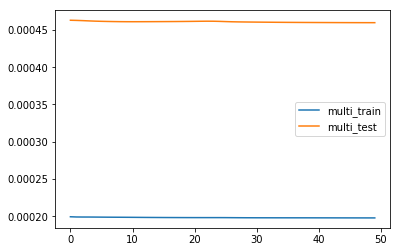

In [75]:
pyplot.plot(multi_history.history['loss'], label='multi_train')
pyplot.plot(multi_history.history['val_loss'], label='multi_test')
pyplot.legend()
pyplot.show()

In [120]:
test_X.shape

(2379, 1, 24)

In [119]:
from keras.models import load_model

multi_model = load_model("8to8market_lstm_growth_rate_model_weights.hdf5")
yhat = multi_model.predict(test_X)

In [77]:
test_y.shape

(2379, 1, 8)

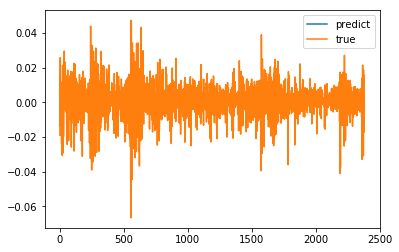

In [78]:
pyplot.plot(yhat[:,0][:,0], label='predict')
pyplot.plot(test_y[:,0][:,0], label='true')
pyplot.legend()
pyplot.show()

In [79]:
#reshape prediction
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [80]:
yhat = yhat.reshape((yhat.shape[0], yhat.shape[2]))

In [81]:
test_X.shape

(2379, 24)

In [82]:
inv_yhat = concatenate((test_X[:, :], yhat), axis=1)

In [83]:
inv_yhat.shape

(2379, 32)

In [84]:
#inv_yhat = scaler.inverse_transform(inv_yhat)

In [85]:
inv_yhat[-1]

array([ 1.5666824e-02,  1.0676157e-02,  1.2987013e-02, -2.4239298e-02,
       -4.3873903e-03, -5.3056027e-03,  2.4002134e-03,  6.0194670e-03,
        1.0851291e-02,  1.0563380e-02,  9.6153850e-03, -1.1099366e-02,
       -8.5278274e-03,  3.0581041e-03,  8.8683929e-04, -3.8192235e-03,
        1.0557797e-02, -1.0452962e-02, -3.1746032e-03, -4.7969002e-02,
        1.3333882e-02, -1.3754963e-02, -6.2023744e-04, -1.4952077e-02,
       -8.0630663e-05, -3.2970685e-04,  4.3686974e-04,  5.6636822e-04,
        5.6370022e-04, -3.7242097e-04,  1.1780937e-03,  5.4991065e-04],
      dtype=float32)

In [86]:
#inv_yhat[:,-8:].shape

In [87]:
inv_yhat = inv_yhat[:,-8:]

In [88]:
inv_yhat[0]

array([-0.00155938, -0.00350986,  0.00045873,  0.00294121,  0.00077744,
       -0.00151391,  0.00237953,  0.00028937], dtype=float32)

In [89]:
#reshape actual
test_y = test_y.reshape((test_y.shape[0], test_y.shape[2]))

In [90]:
test_y.shape

(2379, 8)

In [91]:
inv_y = concatenate((test_X[:, :], test_y), axis=1)

In [92]:
#inv_y = scaler.inverse_transform(inv_y)

In [93]:
inv_y[-1]

array([ 0.01566682,  0.01067616,  0.01298701, -0.0242393 , -0.00438739,
       -0.0053056 ,  0.00240021,  0.00601947,  0.01085129,  0.01056338,
        0.00961538, -0.01109937, -0.00852783,  0.0030581 ,  0.00088684,
       -0.00381922,  0.0105578 , -0.01045296, -0.0031746 , -0.047969  ,
        0.01333388, -0.01375496, -0.00062024, -0.01495208, -0.00631667,
        0.02464789,  0.02547771, -0.00196491,  0.00077164, -0.00136592,
        0.00265981,  0.00064868], dtype=float32)

In [94]:
#inv_y[:,-8:].shape

In [95]:
inv_y = inv_y[:,-8:]

In [96]:
inv_y[:,0].shape

(2379,)

In [97]:
rmse = sqrt(mean_squared_error(inv_y[:,0], inv_yhat[:,0]))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.009


In [98]:
predictDates = data.tail(len(inv_y)).index
actual_chart = go.Scatter(x=predictDates, y=inv_y[:,0], name= 'Actual Price')
multi_predict_chart = go.Scatter(x=predictDates, y=inv_yhat[:,0], name= 'Multi Predict Price')
py.iplot([multi_predict_chart, actual_chart])